# **INTRODUCTION**

Fraud detection is a set of activities undertaken to prevent money or property from being obtained through false pretenses. It's an important problem of many industries such as banking or e-commerce. One of methods to detect fraud is using machine learning. 

Type: Classification

Data source: https://www.kaggle.com/preritsaxena/fraud-detection


# **IMPORTING THE LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# **EXPLORING THE DATA**

In [2]:
data = pd.read_csv("Fraud_Data.csv")
data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 3:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 7:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


The data set has 151112 records and 11 features.

In [3]:
data.shape

(151112, 11)

The data set has 6 object features.

In [4]:
data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
is_fraud            int64
dtype: object

Now, I convert 2 object features to datetime features.

In [5]:
data['signup_time'] = data['signup_time'].astype('datetime64[ns]')
data['purchase_time'] = data['purchase_time'].astype('datetime64[ns]')

In [6]:
data.nunique()

user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143511
is_fraud               2
dtype: int64

Checking the number of unique values of each column, we can see that there are 2 columns which have 151112 unique values. One of them is *user_id* and it's not significant for the model. Therefore, it should be dropped.

In [7]:
data.drop(['user_id'], inplace = True, axis = 1)

There are no missing values. 

In [8]:
data.isnull().sum()

signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

In [9]:
data.describe(percentiles = [.1, .25, .5, .75, .95, .99])

,purchase_value,age,ip_address,is_fraud
count,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,36.935372,33.140704,2.152145e+09,0.093646
std,18.322762,8.617733,1.248497e+09,0.291336
min,9.000000,18.000000,5.209350e+04,0.000000
10%,15.000000,22.000000,4.165716e+08,0.000000
25%,22.000000,27.000000,1.085934e+09,0.000000
50%,35.000000,33.000000,2.154770e+09,0.000000
75%,49.000000,39.000000,3.243258e+09,0.000000
95%,70.000000,48.000000,4.086293e+09,1.000000
99%,87.000000,55.000000,4.251291e+09,1.000000


There are just 4 numerical features. We can see from the table that seems the data don't have many outliers. There may be some outliers in age but they are not very significant. 

Before visualizing the data, we need to process time data. I will replace *signup_time* by the difference between *signup_time* and *purchase_time*. Then, I will split *purchase_time* into 4 parts: year, month, day and hour.

In [10]:
data["signup_time"] = (data["purchase_time"] - data["signup_time"]).dt.total_seconds() / 86400

In [11]:
data["purchase_time_year"] = data["purchase_time"].dt.year
data["purchase_time_month"] = data["purchase_time"].dt.month
data["purchase_time_day"] = data["purchase_time"].dt.day
data["purchase_time_hour"] = data["purchase_time"].dt.hour


Then, I drop *purchase_time*.

In [12]:
data.drop(['purchase_time'], inplace = True, axis = 1)

In [13]:
data.nunique()

signup_time            143513
purchase_value            122
device_id              137956
source                      3
browser                     5
sex                         2
age                        58
ip_address             143511
is_fraud                    2
purchase_time_year          1
purchase_time_month        12
purchase_time_day          31
purchase_time_hour         24
dtype: int64

*purchase_time_year* has only one unique value. Therefore, I will drop it.

In [14]:
data.drop(['purchase_time_year'], inplace = True, axis = 1)

*device_id* is a categorical columns and has many unique values. It should be removed from the dataset 

In [15]:
data.drop(['device_id'], inplace = True, axis = 1)

# **Visualization**

In [16]:
numeric = data.select_dtypes(exclude=object).columns
category = data.select_dtypes(include=object).columns

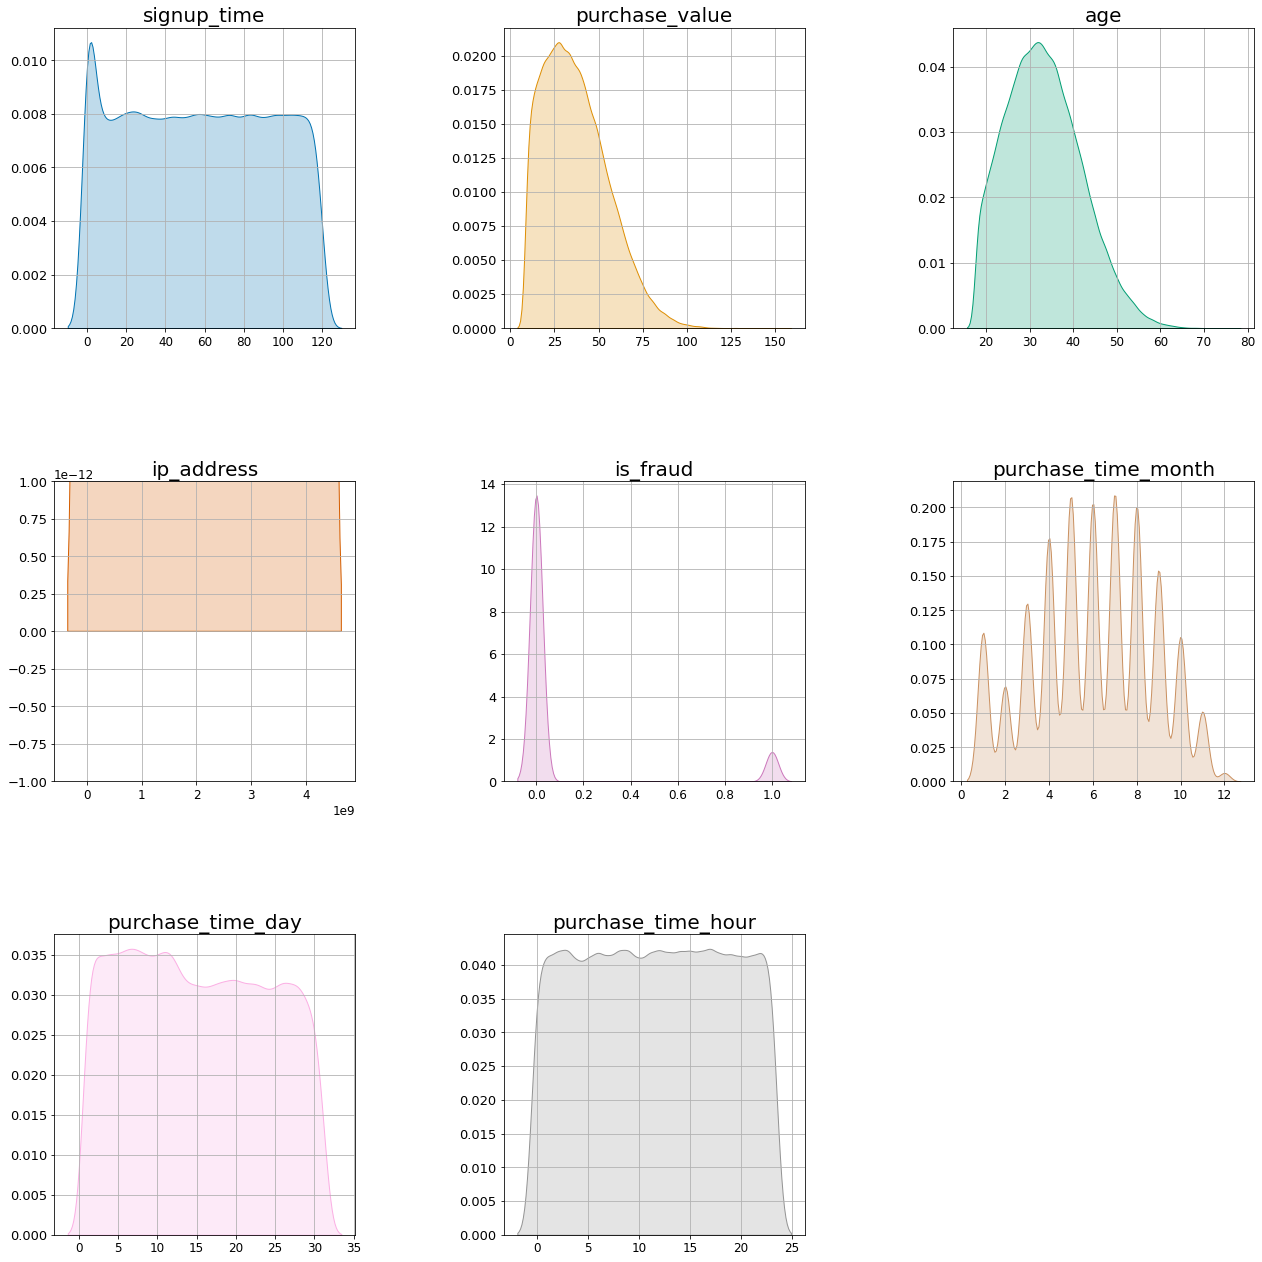

In [17]:
fig, ax = plt.subplots(figsize =(20, 20))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12

colors = sns.color_palette("colorblind", n_colors = 12).as_hex()

for i in (enumerate(numeric)):
    plt.subplot(3, 3, i[0]+1)
    sns.kdeplot(x = i[1], data = data, color = colors[i[0]], fill=True)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    # plt.box(False)
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=8.0)
    plt.grid(b=None)

There are 8 histograms, I will describe the main characteristics of them:


*   ***purchase_value*** and ***age*** have quite symmetric distributions. Their skewnesses may be in the range (-1, 1).
*   ***signup_time:*** The plot has the glocal maximum at 0. It means that many transactions took place on the sign up days.
*   ***ip_address:*** The plot is quite special probably because ip addresses don't have a linear relationship. 
*   ***is_fraud:*** We can see from the chart that the number of safe transaction is overwhelming. There's about over 10% of fraud transactions.
*   ***purchase_time_month:*** Most of transactions took place from April to October.
*   ***purchase_time_day:*** There were more transactions taking place in first half month than the second half.
*   ***purchase_time_hour:*** The probability of transactions taking place at all times of the day was the same.











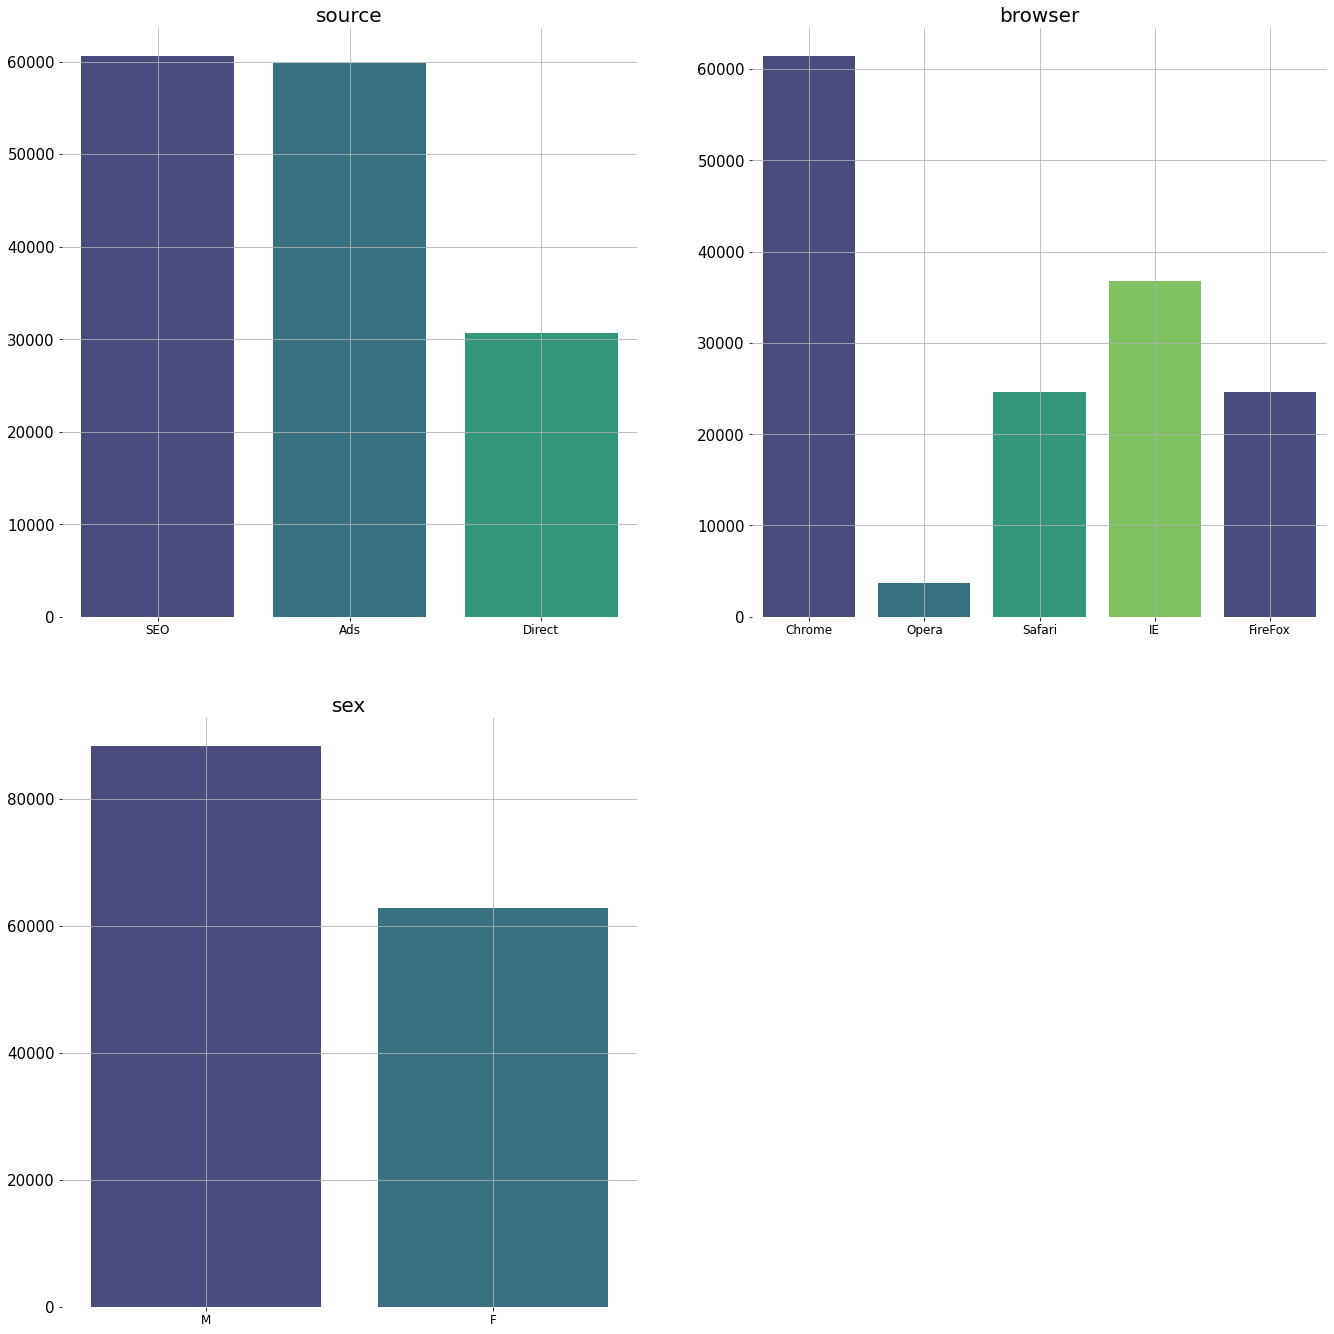

In [18]:
fig, ax = plt.subplots(figsize =(20, 20))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("viridis", n_colors = 4).as_hex()
for i in (enumerate(category)):
  plt.subplot(2, 2, i[0]+1)
  sns.countplot(x = i[1], data = data, palette = colors, fill=True)
  plt.xlabel('')
  plt.ylabel('')
  plt.yticks(fontsize = 15, color='black')
  plt.box(False)
  plt.title(i[1], fontsize=20, color='black')
  plt.tight_layout(pad=5.0)
  plt.grid(b=None)

*   ***source:*** The number of 'SEO' and 'Ads' is the same (~60000).
*   ***browser:*** The quatity of transactions taking place on Chrome browser is the most. Next is IE browser.
*   ***sex:*** The quantity of male is more than the female's.







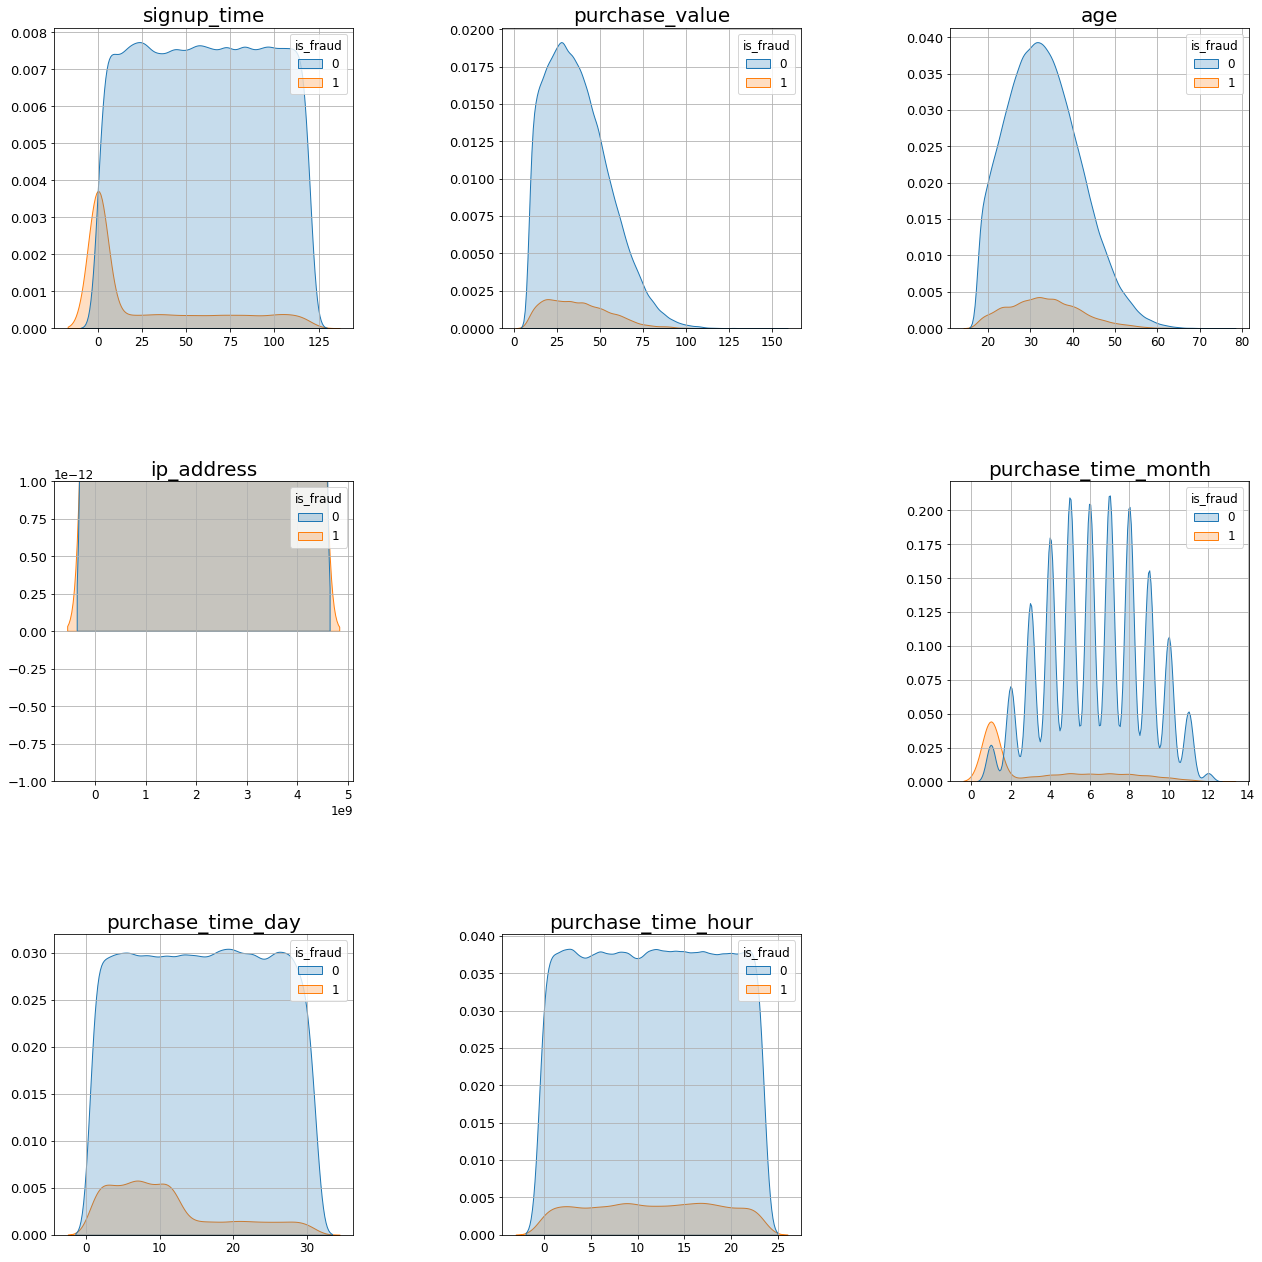

In [19]:
fig, ax = plt.subplots(figsize =(20, 20))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12

colors = sns.color_palette("colorblind", n_colors = 12).as_hex()

for i in (enumerate(numeric)):
    if i[1] == "is_fraud":
      continue
    plt.subplot(3, 3, i[0]+1)
    sns.kdeplot(x = i[1], data = data, color = colors[i[0]], fill=True, hue="is_fraud")
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=8.0)
    plt.grid(b=None)

We can see from these charts:
*   ***signup_time:*** Most of fraud transactions took place on the first days of registration.
*   ***purchase_time_month:*** Most of fraud transactions took place in January.
*   ***purchase_time_day:*** Most of fraud transactions took place in first half month. 



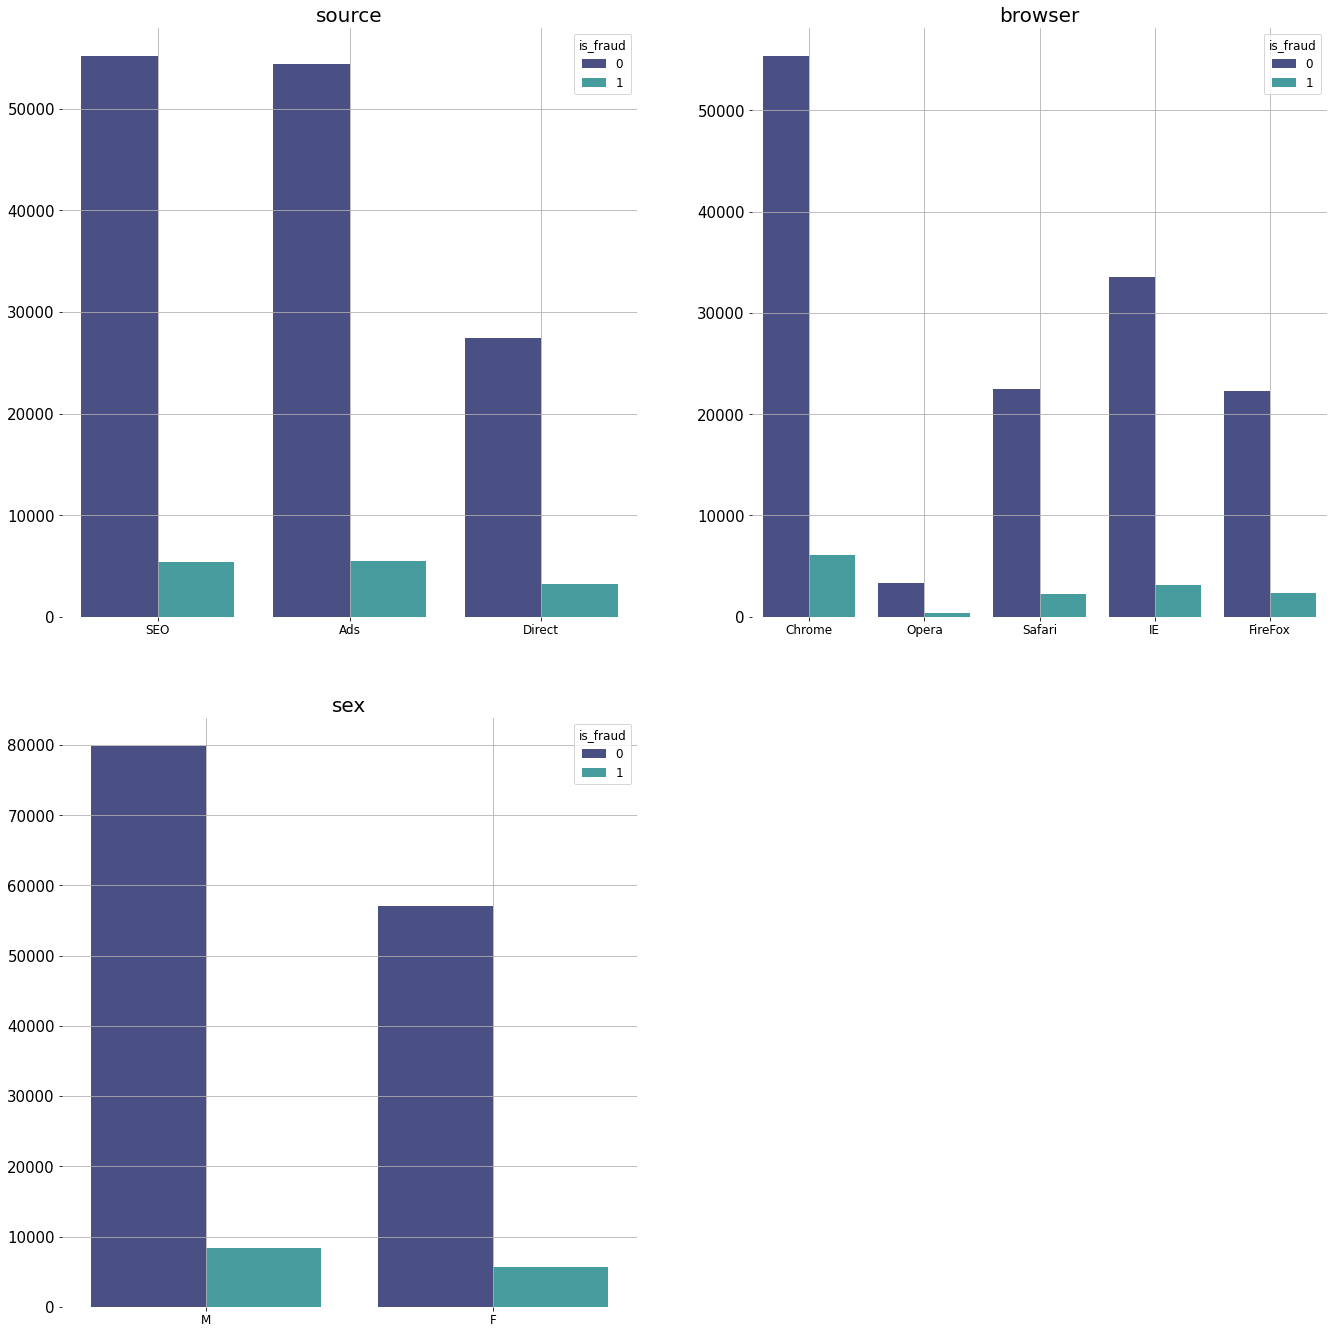

In [20]:
fig, ax = plt.subplots(figsize =(20, 20))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("mako", n_colors = 2).as_hex()
for i in (enumerate(category)):
  plt.subplot(2, 2, i[0]+1)
  sns.countplot(x = i[1], data = data, palette = colors, fill=True, hue="is_fraud")
  plt.xlabel('')
  plt.ylabel('')
  plt.yticks(fontsize = 15, color='black')
  plt.box(False)
  plt.title(i[1], fontsize=20, color='black')
  plt.tight_layout(pad=5.0)
  plt.grid(b=None)

In [21]:
feature_m2 = []
feature_l2 = []

for i in data.columns:
  if data[i].nunique() > 2 and data[i].dtypes != object:
    feature_m2.append(i)
  else:
    feature_l2.append(i)

In [22]:
feature_l2

['source', 'browser', 'sex', 'is_fraud']

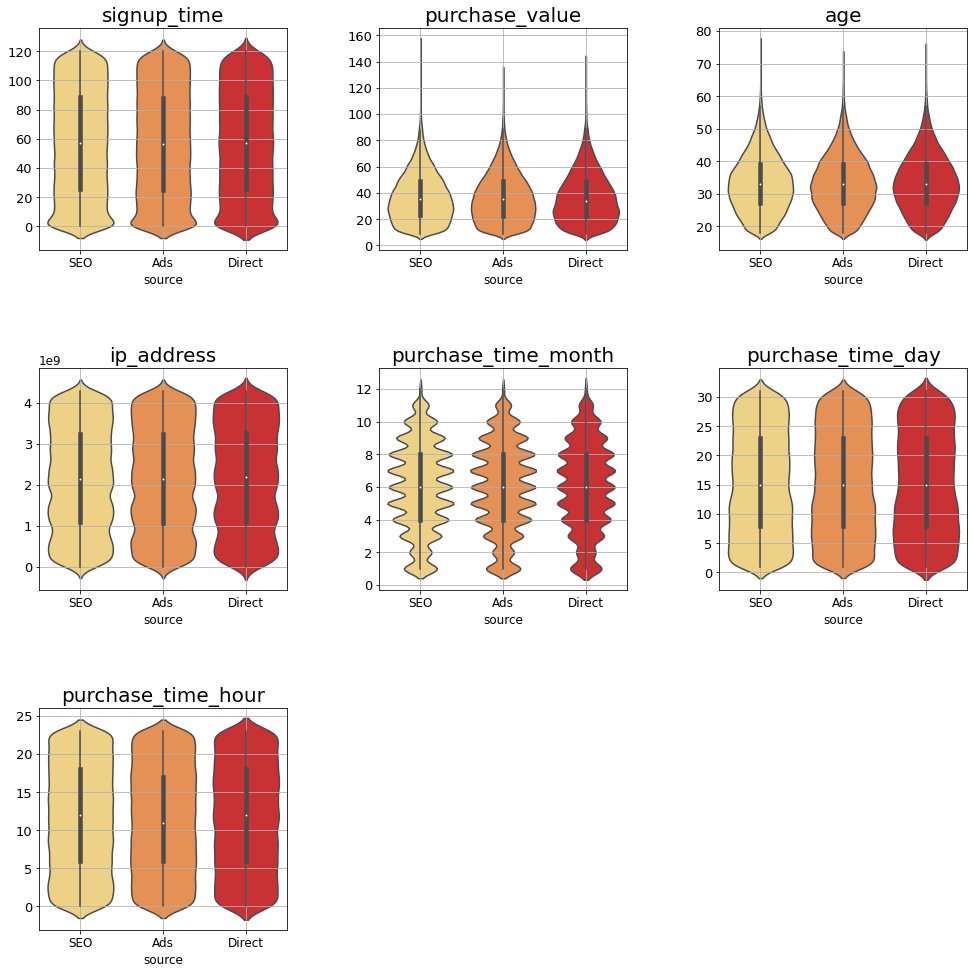

In [23]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("YlOrRd", n_colors = 3).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='source', y=i[1], palette = colors, data=data)
    plt.xlabel('source')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

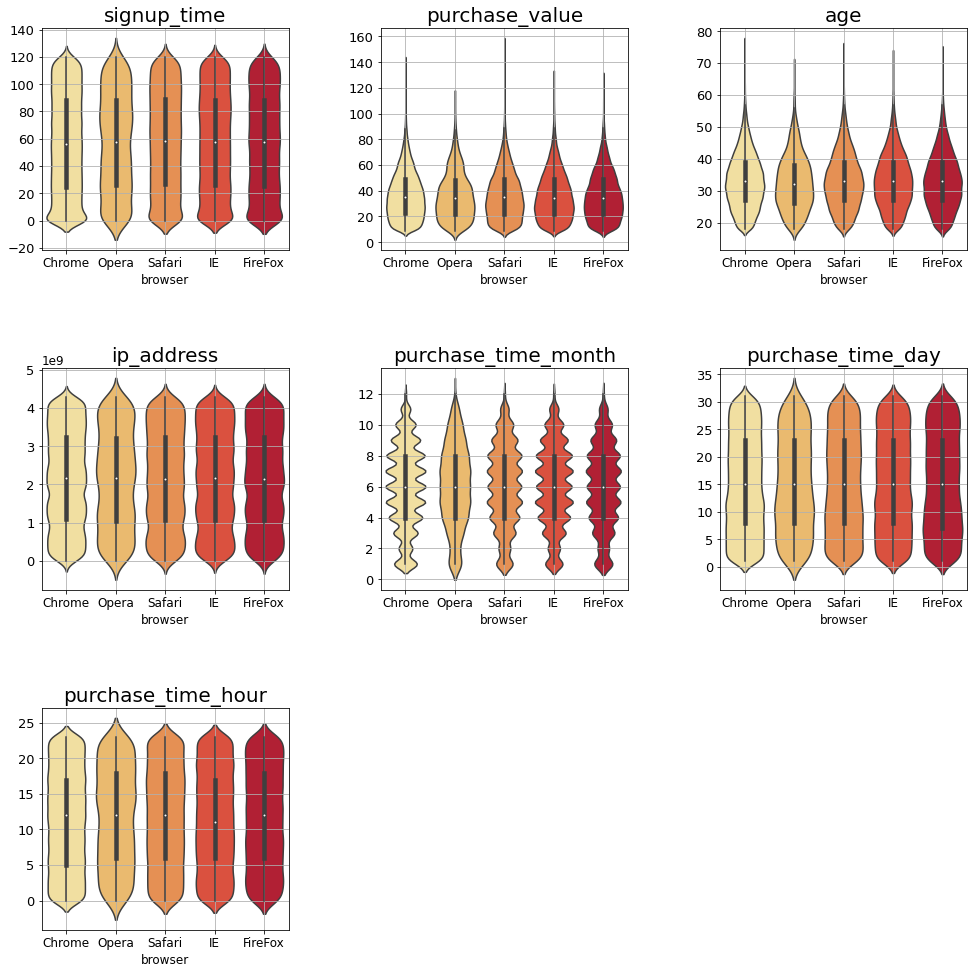

In [24]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("YlOrRd", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='browser', y=i[1], palette = colors, data=data)
    plt.xlabel('browser')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

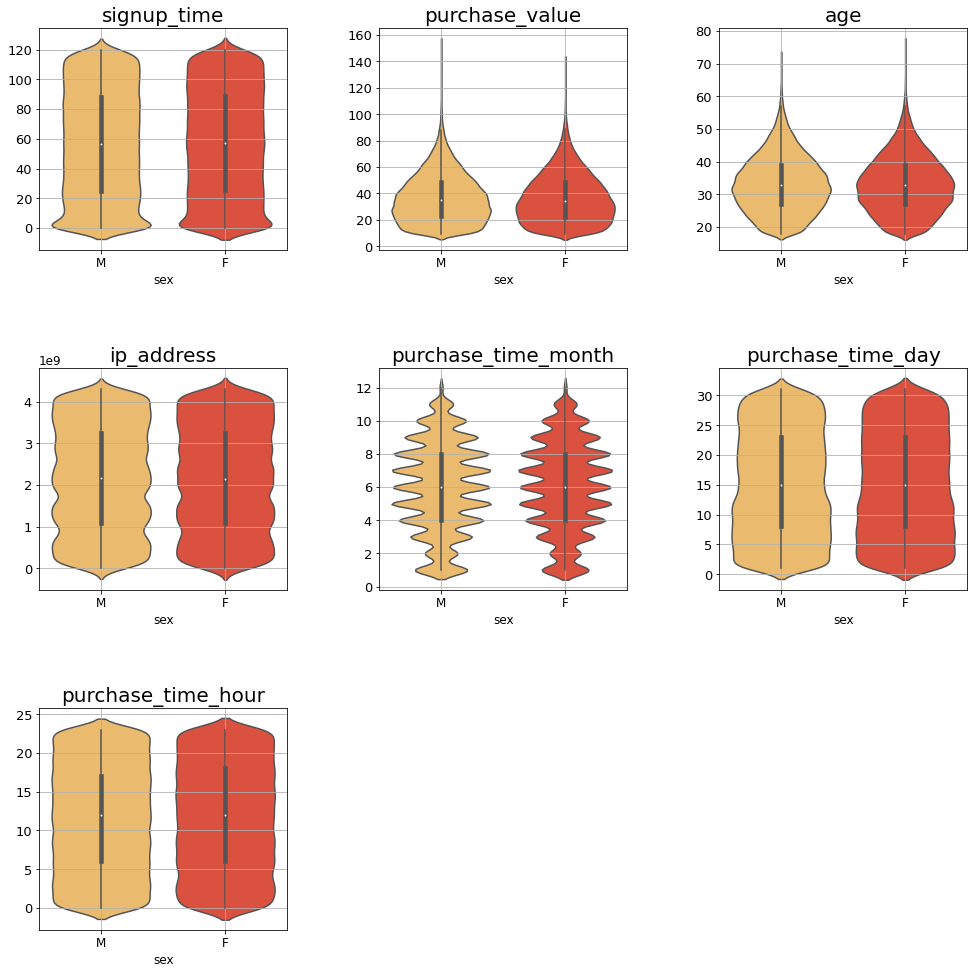

In [25]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("YlOrRd", n_colors = 2).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='sex', y=i[1], palette = colors, data=data)
    plt.xlabel('sex')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

With categorical features which have more than 2 unique values, I use One-Hot Encoding method. 

With sex, I replace 'M' by '0' and 'F' by '1'.

In [26]:
data = data.join(pd.get_dummies(data['source'], prefix='source'))
data = data.join(pd.get_dummies(data['browser'], prefix='browser'))
data = data.drop('source',axis = 1)
data = data.drop('browser',axis = 1)

In [27]:
data['sex'] = data['sex'].replace('M', 0)
data['sex'] = data['sex'].replace('F', 1)

Then, I use heatmap to visualize the correlations between features. 

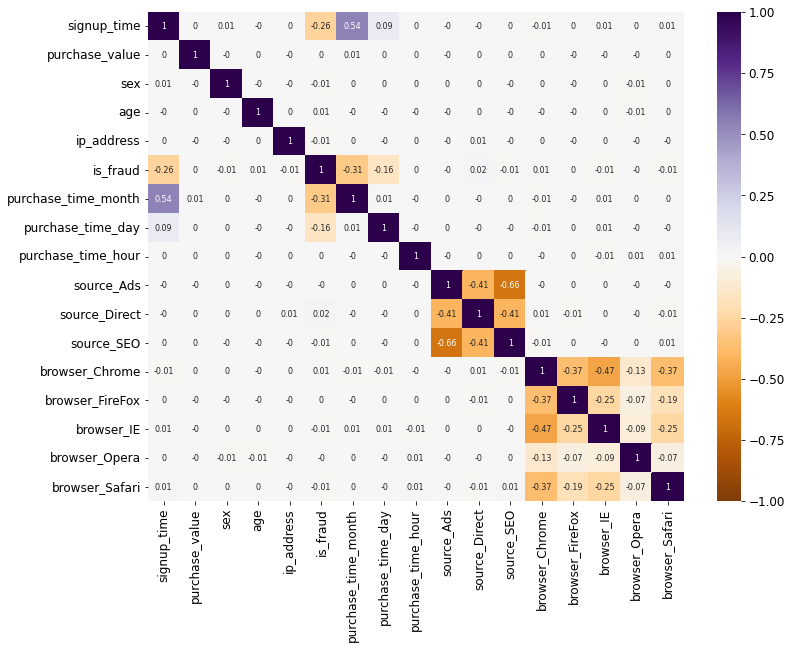

In [28]:
plt.figure(figsize=(12,9))
correlations = data.corr()
sns.heatmap(round(correlations,2), cmap='PuOr', annot=True, 
            annot_kws={"size": 8}, vmax=1, vmin=-1);

# **PROCESSING DATA**

After checking skewness and kurtosis, we can see that there is no concrete features in range (-1, 1). Therefore, we shoudn't to normalize them.

In [29]:
data.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
signup_time,0.018887,-1.223718
purchase_value,0.670485,0.138292
sex,0.342053,-1.883025
age,0.425481,-0.173400
ip_address,-0.007053,-1.210661
is_fraud,2.789626,5.782091
purchase_time_month,-0.097849,-0.762689
purchase_time_day,0.078933,-1.202319
purchase_time_hour,-0.004137,-1.200369
source_Ads,0.424156,-1.820115


# **PCA**

I will use PCA method to reduce dimension of the dataset to 8.

In [30]:
iris_lm=ols('is_fraud ~  signup_time + purchase_value + sex + age + ip_address + purchase_time_month + purchase_time_day + purchase_time_hour + source_Ads + source_Direct + source_SEO + browser_Chrome + browser_FireFox + browser_IE + browser_Opera + browser_Safari', data=data).fit() 
a = sm.stats.anova_lm(iris_lm, typ=2)

In [31]:
a = a.sort_values(by='PR(>F)')
b = a.head(8)
b

,sum_sq,df,F,PR(>F)
purchase_time_month,558.441284,1.0,7561.123618,0.000000e+00
purchase_time_day,280.191777,1.0,3793.710673,0.000000e+00
source_Ads,268.881751,1.0,3640.576400,0.000000e+00
source_Direct,269.133171,1.0,3643.980546,0.000000e+00
source_SEO,252.608316,1.0,3420.239077,0.000000e+00
browser_Chrome,110.674105,1.0,1498.493412,0.000000e+00
signup_time,106.309541,1.0,1439.398561,1.748125e-313
browser_FireFox,64.087656,1.0,867.727196,3.531100e-190


# **Building the model**

## **Splitting the dataset**

The dataset is splited into 2 parts: the training set and the validation set with a ratio of 8:1.

In [32]:
features = b.index
features


Index(['purchase_time_month', 'purchase_time_day', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'signup_time',
       'browser_FireFox'],
      dtype='object')

In [33]:
y = data['is_fraud']
X = pd.DataFrame(data, columns = features)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=25)

With training set, we need to use SMOTE() to balance the ratio between the two labels.

In [35]:
smt = SMOTE(sampling_strategy=.6)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [36]:
y_train.value_counts()

0    109564
1     65738
Name: is_fraud, dtype: int64

## **Logistic Regression**

In [37]:
LogR = LogisticRegression(random_state=10).fit(X_train, y_train)
LogR.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.8889587400324256

Text(0.5, 1.0, 'Confusion Matrix')

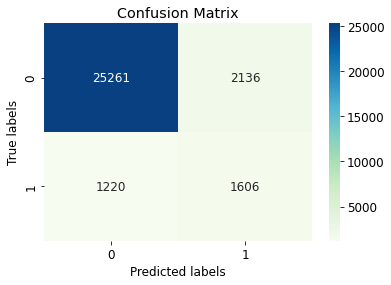

In [38]:
y_pred = LogR.predict(X_test)
cm_LogR = confusion_matrix(y_test, y_pred)

LogR_mx = plt.subplot()
sns.heatmap(cm_LogR, annot=True, fmt='g', cmap='GnBu', ax = LogR_mx)
# labels, title and ticks
LogR_mx.set_xlabel('Predicted labels')
LogR_mx.set_ylabel('True labels')
LogR_mx.set_title('Confusion Matrix')

## **Decision Tree**

In [39]:
DT = DecisionTreeClassifier(max_depth=8, random_state=10)
DT.fit(X_train, y_train)
DT.score(X_test, y_test)

0.9556298183502631

Text(0.5, 1.0, 'Confusion Matrix')

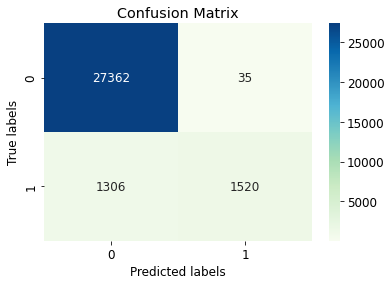

In [40]:
y_pred = DT.predict(X_test)
cm_DT = confusion_matrix(y_test, y_pred)

DT_mx = plt.subplot()
sns.heatmap(cm_DT, annot=True, fmt='g', cmap='GnBu', ax = DT_mx)
# labels, title and ticks
DT_mx.set_xlabel('Predicted labels')
DT_mx.set_ylabel('True labels')
DT_mx.set_title('Confusion Matrix')

## **Gradient Boosting**

In [41]:
GB = GradientBoostingClassifier(random_state=20).fit(X_train, y_train)
GB.score(X_test, y_test)

0.9567547893988022

Text(0.5, 1.0, 'Confusion Matrix')

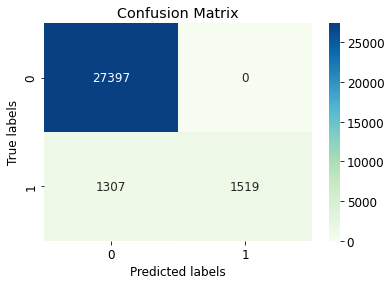

In [42]:
y_pred = GB.predict(X_test)
cm_GB = confusion_matrix(y_test, y_pred)

GB_mx = plt.subplot()
sns.heatmap(cm_GB, annot=True, fmt='g', cmap='GnBu', ax = GB_mx)
# labels, title and ticks
GB_mx.set_xlabel('Predicted labels')
GB_mx.set_ylabel('True labels')
GB_mx.set_title('Confusion Matrix')

## **Naive Bayes**

In [43]:

NB = GaussianNB().fit(X_train, y_train)
NB.score(X_test, y_test)

0.8259272739304503

Text(0.5, 1.0, 'Confusion Matrix')

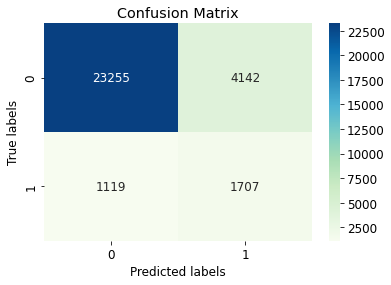

In [44]:
y_pred = NB.predict(X_test)
cm_NB = confusion_matrix(y_test, y_pred)

NB_mx = plt.subplot()
sns.heatmap(cm_NB, annot=True, fmt='g', cmap='GnBu', ax = NB_mx)
# labels, title and ticks
NB_mx.set_xlabel('Predicted labels')
NB_mx.set_ylabel('True labels')
NB_mx.set_title('Confusion Matrix')

## **Plot roc curve**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function 

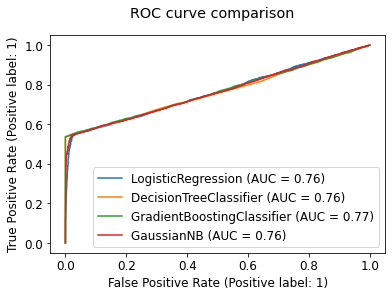

In [46]:
fig = metrics.plot_roc_curve( LogR, X_test, y_test)
fig = metrics.plot_roc_curve( DT, X_test, y_test, ax = fig.ax_)
fig = metrics.plot_roc_curve( GB, X_test, y_test, ax = fig.ax_)
fig = metrics.plot_roc_curve( NB, X_test, y_test, ax = fig.ax_)
fig.figure_.suptitle("ROC curve comparison")
plt.show()

After using 4 models, we can conclude: 

*   There is no model that's really good.
*   Gradient Boosting and Decision Tree are the best for predict true label '0'. Naive Bayes is the the best for predict true label '1'.
*   We can use multiple models for best result.

